In [13]:
import numpy as np
import pandas as pd

In [14]:
from gensim.models import Word2Vec
skipgram = Word2Vec.load('w2vtrain300.bin')

In [15]:
print("The total number of words are : ",len(skipgram.wv))

The total number of words are :  62269


In [16]:
skipgram.wv.similarity('yêu_thích','yêu_mến')

0.6100828

In [17]:
vocab=list(skipgram.wv.index_to_key)

In [18]:
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=skipgram.wv[word]
print("The no of key-value pairs : ",len(word_vec_dict)) 

The no of key-value pairs :  62269


In [19]:
data = pd.read_csv('news_politics_final.csv')

In [20]:
data.head()

,Unnamed: 0,Content,label,Content_processed,LengthContent,LengthContent_processed
0,0,Dân trí trân trọng giới thiệu toàn văn Tuyên ...,real,dân_trí trân_trọng giới_thiệu toàn_văn tuyên_b...,6099,2473
1,1,Tổng Bí thư Nguyễn Phú Trọng hội kiến Chủ tị...,real,tổng_bí_thư nguyễn_phú_trọng hội_kiến chủ_tịch...,689,272
2,2,Tổng Bí thư Nguyễn Phú Trọng hội kiến Chủ tị...,real,tổng_bí_thư nguyễn_phú_trọng hội_kiến chủ_tịch...,598,226
3,3,Thảo luận tại hội trường Quốc hội về dự thảo ...,real,thảo_luận hội_trường quốc_hội dự_thảo luật_phò...,656,226
4,4,Thường trực Ban Bí thư Võ Văn Thưởng hội đà...,real,thường_trực_ban_bí_thư võ_văn_thưởng hội_đàm ủ...,193,77


In [21]:
maxi=-1
for i,rev in enumerate(data['Content_processed']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

3696


In [22]:
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split,cross_validate
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

In [23]:
tok = Tokenizer()
tok.fit_on_texts(data['Content_processed'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(data['Content_processed'])

In [24]:
vocab_size

15809

In [25]:
max_rev_len=1085  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [26]:
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape 

(2092, 1085)

In [27]:
pad_rev[0]

array([ 61, 276, 322, ..., 532, 226,  27])

In [28]:
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector

In [29]:
print(embed_matrix[14])

[-0.28183103 -0.03912653  0.10056827  0.03901356  0.02785202 -0.31145567
 -0.03024101  0.45011729 -0.13029948 -0.23684879 -0.36536217  0.2560862
 -0.09882434  0.12620136 -0.24207723 -0.28044248  0.53277868  0.00768296
  0.40378445  0.06528721 -0.114248   -0.32382485  0.05861918 -0.16303404
  0.21226084 -0.10544066  0.04176835 -0.29302406 -0.23391014  0.15610525
 -0.14662646 -0.17257653 -0.04311708 -0.43926942 -0.12563704  0.1548277
 -0.26053938 -0.03665499 -0.39927766 -0.3079522  -0.243477   -0.13371997
 -0.1634859   0.03712539  0.0954267   0.37649038  0.07492974 -0.05473397
 -0.15644701 -0.11560234  0.1857481  -0.13930148  0.19776966 -0.17389007
 -0.12496211  0.03939854  0.16503991 -0.25681877  0.05824628 -0.01610592
 -0.23790444 -0.50178903 -0.58323836 -0.14671637  0.50868982  0.25095317
  0.12086596 -0.05767003 -0.35980478  0.22709617 -0.07917779 -0.10323571
  0.37461233  0.57669365 -0.014022    0.38817742 -0.43517086  0.00539866
 -0.13564549  0.18053196  0.2712591  -0.16669835  0.2

In [30]:
pad_rev[0]

array([ 61, 276, 322, ..., 532, 226,  27])

In [31]:
pad_rev[1]

array([62, 84, 60, ...,  0,  0,  0])

In [37]:
label_num=[]

In [38]:
for i in range(len(data)):
    if data.label[i]=='real':
        label_num.append(1)
    else:
        label_num.append(0)

In [39]:
data['label_num']=label_num

In [40]:
Y=keras.utils.to_categorical(data['label_num'])  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=42)

In [41]:
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

In [42]:

model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix)))
# model.add(CuDNNLSTM(64,return_sequences=False)) # loss stucks at about 
model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
model.add(Dense(2,activation='sigmoid'))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1085, 300)         4742700   
                                                                 
 flatten (Flatten)           (None, 325500)            0         
                                                                 
 dense (Dense)               (None, 16)                5208016   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 9,950,750
Trainable params: 9,950,750
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-2),loss='binary_crossentropy',metrics=['accuracy'])

C:\Users\hotai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
model.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.01>

In [46]:
epochs=50
batch_size=64

In [47]:
x_train[0]

array([54, 75, 74, ...,  0,  0,  0])

In [48]:
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test,y_test))

Epoch 1/50
27/27 [==============================] - 10s 286ms/step - loss: 6.1392 - accuracy: 0.5158 - val_loss: 0.6926 - val_accuracy: 0.5370
Epoch 2/50
27/27 [==============================] - 8s 310ms/step - loss: 0.7426 - accuracy: 0.5099 - val_loss: 0.6913 - val_accuracy: 0.5370
Epoch 3/50
27/27 [==============================] - 7s 266ms/step - loss: 0.7464 - accuracy: 0.5218 - val_loss: 0.6909 - val_accuracy: 0.5370
Epoch 4/50
27/27 [==============================] - 8s 305ms/step - loss: 1.1455 - accuracy: 0.5224 - val_loss: 0.6916 - val_accuracy: 0.5370
Epoch 5/50
27/27 [==============================] - 8s 279ms/step - loss: 0.7394 - accuracy: 0.5206 - val_loss: 0.6909 - val_accuracy: 0.5370
Epoch 6/50
27/27 [==============================] - 8s 287ms/step - loss: 0.7398 - accuracy: 0.5206 - val_loss: 0.6910 - val_accuracy: 0.5370
Epoch 7/50
27/27 [==============================] - 8s 279ms/step - loss: 0.6953 - accuracy: 0.5200 - val_loss: 0.6910 - val_accuracy: 0.5370
Epoch

In [49]:
from matplotlib import pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


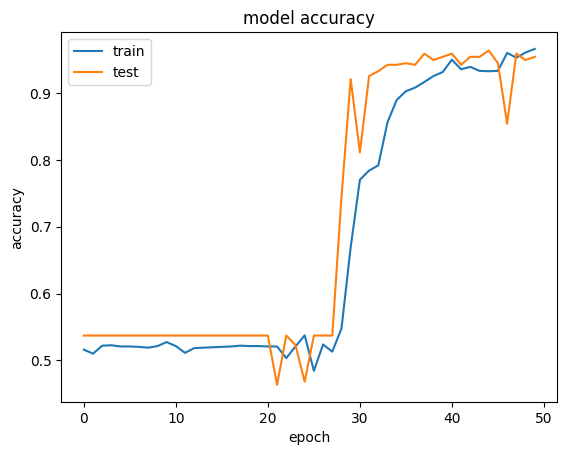

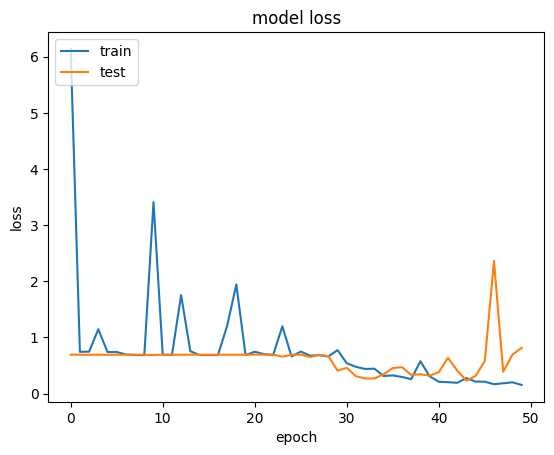

In [50]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
from keras.models import load_model

In [52]:
model.save('LSTM_model.h5') 
del model

In [53]:
model = load_model('LSTM_model.h5')

In [54]:
model.evaluate(x_test,y_test)

14/14 [==============================] - 1s 41ms/step - loss: 0.8131 - accuracy: 0.9547


[0.8131487965583801, 0.9546539187431335]